# 3. Basic Exploratory Data Analysis

#### Goal of this notebook: To perform some Exploratory Data Analysis - especially using maps to interactively visualize event densities across time

In [53]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
import datetime
from datetime import *
from dateutil.parser import parse
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import datetime
import json
sns.set_style("whitegrid")
sns.set_context("poster")

In [27]:
# Country code mapping from FPS to ISO 3166
#http://www.opengeocode.org/download/fips2iso.txt
import csv
reader = csv.reader(open('fips2iso.txt', 'r'))
fipsToIsoDict = {}
for row in reader:   
   fipsToIsoDict[row[0]] = row[2]

fipsToIsoDict.pop("", None)

In [2]:
sc

In [3]:
#input: globalEventId (int), eventDate (date), eventMonth(int), eventYear(int), eventCode(int), 
# eventBaseCode (Int), eventRootCode (int), quadClass (int), goldsteinScale (float), 
#numArticles(int), avgTone(float), actionGeoCountryCode(string)
def parseCoreRdd(strRecord):
    rec = strRecord.split(',')
    return (int(rec[0]), parse(rec[1]).date(), int(rec[2]), int(rec[3]), int(rec[4]), \
            int(rec[5]), int(rec[6]), int(rec[7]), float(rec[8]), \
            int(rec[9]), float(rec[10]), rec[11])

coreDataRdd = sc.textFile("s3://gdeltdata/coredata/*").map(parseCoreRdd)
coreDataRdd.cache()

PythonRDD[2] at RDD at PythonRDD.scala:43

In [5]:
%%time
coreDataRdd.count()

CPU times: user 208 ms, sys: 52 ms, total: 260 ms
Wall time: 30min 59s


221411551

## Data Model
* capturing two actors and the action performed by Actor1 upon Actor2
* Goldstien score: this score is based on the type of event, not the specifics of the actual event record being recorded – thus two riots, one with 10 people and one with 10,000, will both receive the same Goldstein score
* AvgTone. (numeric) This is the average “tone” of all documents containing one or more mentions of this event. The score ranges from -100 (extremely negative) to +100 (extremely positive). Common values range between -10 and +10, with 0 indicating neutral.

## Ideas
* Goldstien score can be aggregated to various levels of time resolution to yield an approximation of the stability of a location over time.
* NumMentions: This is the total number of mentions of this event across all source documents. Multiple references to an event within a single document also contribute to this count. This can be used as a method of assessing the “importance” of an event: the more discussion of that event, the more likely it is to be significant.
    * Normalize NumMentions, NumArticles & NumSources: The total universe of source documents and the density of events within them vary over time, so it is recommended that this field be normalized by the average or other measure of the universe of events during the timeperiod of interest. 
* Remove duplicate events: NOTE from NumMentions/NumSources/NumArticles definition: this field is updated over time if news articles published later discuss this event (for example, in the weeks after a major bombing there will likely be numerous news articles published mentioning the original bombing as context to new developments, while on the one-year anniversary there will likely be further coverage). At this time the daily event stream only includes new event records found each day and does not include these updates; a special “updates” stream will be released in Fall 2013 that will include these.

## Data Exploration

* Total events: 360,142,405
* Total root events: 232,115,641
* Total root events where ActionGeo_CountryCode is null: 7,307,887
* Total root events where Actor1Geo_CountryCode is null: 27,775,769
* Total root events where Actor1Geo_CountryCode is null: 63,462,265 

* Total root events were EventRootCode is not valud (not in "01", "02".."20) : 58
* First event date: 1979-01-01
* Last event date: 2016-01-31

## USA 1995 to 2005

In [81]:
#input: globalEventId (int), eventDate (date), eventMonth(int), eventYear(int), eventCode(int), 
# eventBaseCode (Int), eventRootCode (int), quadClass (int), goldsteinScale (float), 
#numArticles(int), avgTone(float), actionGeoCountryCode(string)
usa95To05Rdd = coreDataRdd.filter(lambda x: x[11]=="US" and x[3] >1994 and x[3] < 2006)
usa95To05Data = usa95To05Rdd.map(lambda x: (x[1].replace(day=1), 1)).reduceByKey(add).collect()

yearList, countList = zip(*usa95To05Data)
yearList, countList = sortListsByFirstList(yearList, countList)

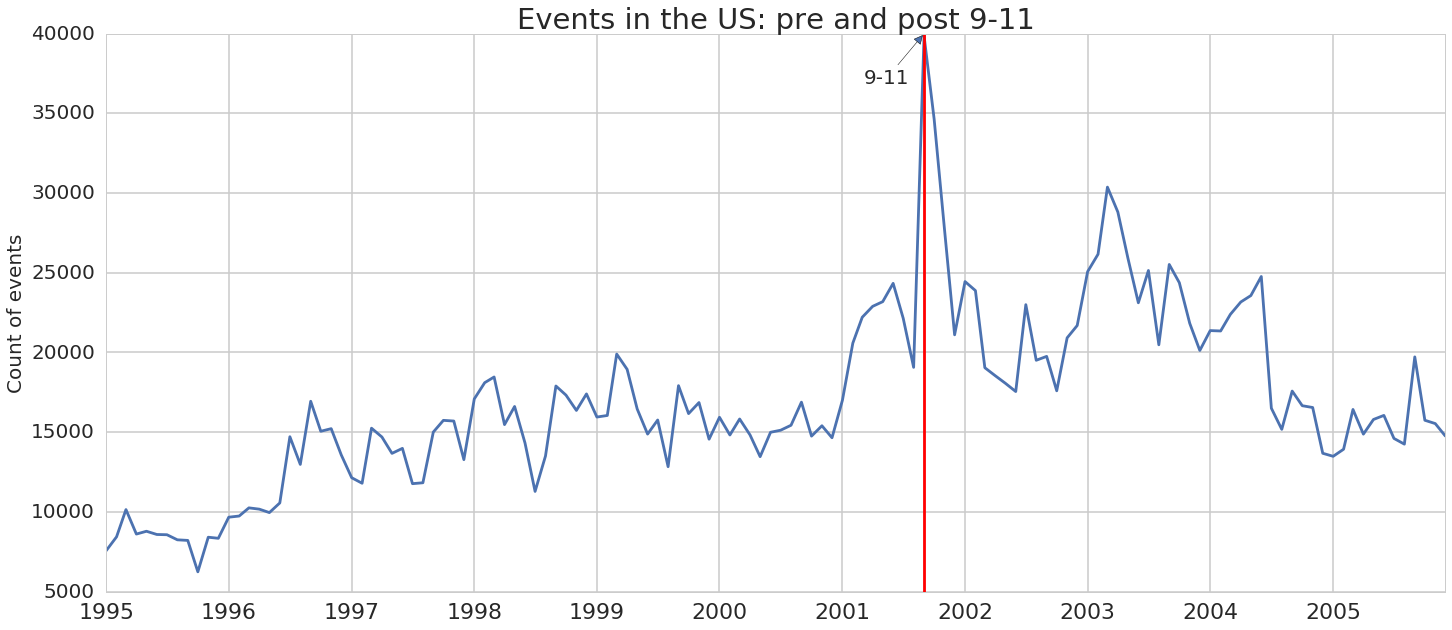

In [115]:
import matplotlib.dates as mdates
import datetime

strDates = [dd.strftime("%b %Y") for dd in yearList]
nineEleven= datetime.date(2001, 9, 1) #Sep 2011

plt.figure(figsize=(24,10))
plt.plot(yearList, countList)
#plt.plot(yearList, countList, "bo")
#plt.xticks(sl_dates, strDates, rotation='vertical', fontsize = 20)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 20)

plt.ylabel("Count of events",  fontsize = 20)
plt.title("Events in the US: pre and post 9-11", fontsize = 29)

plt.axvline(nineEleven, color='r')
plt.annotate('9-11', (mdates.date2num(nineEleven), 40000), xytext=(-60, -50), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'), fontsize = 20)

plt.show()

## Events Timeline (interactive map)

In [ ]:
#from operator import add
allEvents = coreDataRdd.map(lambda x: ((x[1].replace(day=1)),((x[1].replace(day=1), x[11], 1))

In [10]:
coreDataRdd.map(lambda x: ((x[1].replace(day=1)),((x[1].replace(day=1), x[11], 1)))).groupByKey().take(2)

[(datetime.date(2007, 8, 1),
  <pyspark.resultiterable.ResultIterable at 0x7f5ca7d418d0>),
 (datetime.date(2006, 7, 1),
  <pyspark.resultiterable.ResultIterable at 0x7f5ca7d8aa10>)]

In [22]:
%%time
from operator import add
allEvents = coreDataRdd.map(lambda x: ((x[1].replace(day=1), x[11]),1)).reduceByKey(add)\
                .map(lambda y: (y[0][0], (y[0][1], y[1]))).groupByKey().mapValues(list)\
                .collect()

CPU times: user 80 ms, sys: 36 ms, total: 116 ms
Wall time: 1min 11s


In [49]:
# Create the json file 
jsonInput = []
for currentData in allEvents:
    currentDict = {}
    currentDict["timePeriod"] = currentData[0].strftime("%b%Y")
    dataList=[]
    for currentCountryData in currentData[1]:
        
        if not currentCountryData[0] in fipsToIsoDict:
            continue
            
        currentCountryDataDict = {}
        currentCountryDataDict["country"] =  fipsToIsoDict[currentCountryData[0]]
        currentCountryDataDict["eventCount"] =  currentCountryData[1]
        dataList.append(currentCountryDataDict)
    
    currentDict["data"] = dataList
    jsonInput.append(currentDict)

import io
with io.open('countryEventDataOptimal.json.js', 'w', encoding='utf-8') as f:
    f.write(unicode("var timeEventData= "))
    f.write(unicode(json.dumps(jsonInput, ensure_ascii=False)))

In [2]:
%%HTML
<iframe src="Events Map.html" width="1000" height="700">
</iframe>

## Appendix (Sandbox)

In [96]:
 datetime.datetime.now().replace(year=2001)

datetime.datetime(2001, 2, 20, 15, 6, 34, 301117)

In [100]:
ss.replace(year=2001).date()

datetime.date(2001, 2, 20)

In [39]:
print datetime.datetime.now().strftime("%b%Y")

Feb2016


In [65]:
!pip install plotly

    100% |████████████████████████████████| 548kB 740kB/s 
  Running setup.py bdist_wheel for plotly ... - done
  Stored in directory: /home/hadoop/.cache/pip/wheels/ec/d0/d4/1d0e15b553f4f58e02ced7ed5fe43ec767315eb5b3716eed0b
Successfully built plotly


In [66]:
!ls

anaconda2	    countryEventDataOptimal.json.js  fips2iso.txt
configure-spark.sh  EDA - Map (events).ipynb	     Untitled.ipynb


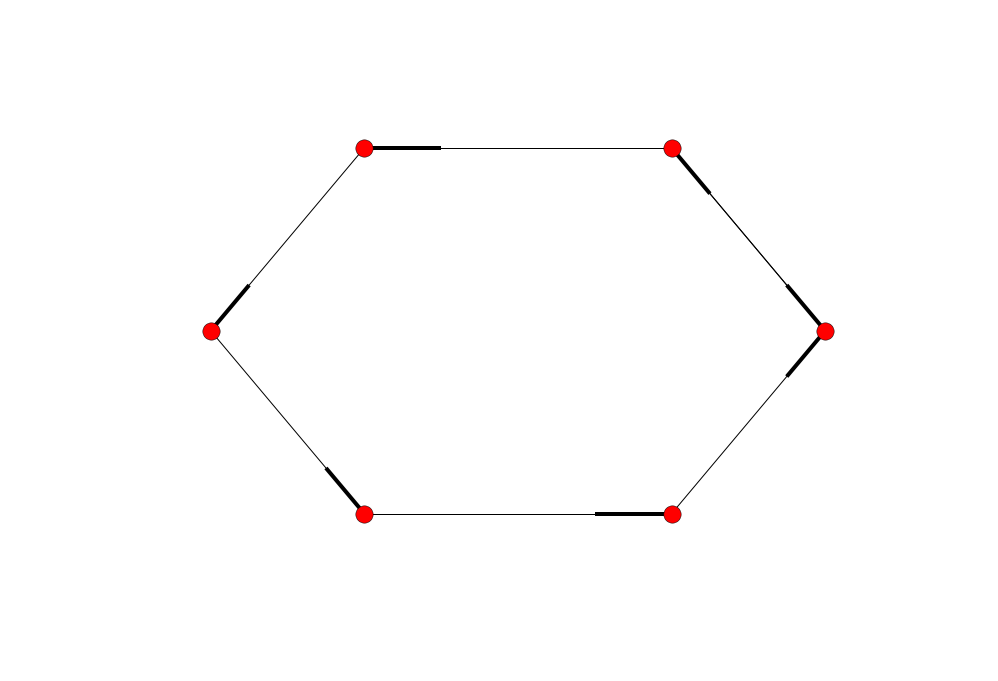

In [90]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph):

    # extract nodes from graph
    nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])

    # create networkx graph
    G=nx.DiGraph()

    # add nodes
    for node in nodes:
        G.add_node(node)

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # draw graph
    pos = nx.shell_layout(G)
    nx.draw(G, pos)

    # show graph
    plt.show()

# draw example
graph = [(20, 21),(21, 20),(21, 22),(22, 23), (23, 24),(24, 25), (25, 20)]
draw_graph(graph)

### Year VS Events

In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

print __version__ # requires version >= 1.9.0

init_notebook_mode() # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
    
    #Sort by date
def sortListsByFirstList(l1, l2):
    l1 = np.array(l1)
    l2 = np.array(l2)
    inds = l1.argsort()
    l1 = l1[inds]
    l2 = l2[inds]
    return l1, l2

#input: globalEventId (int), eventDate (date), eventMonth(int), eventYear(int), eventCode(int), 
# eventBaseCode (Int), eventRootCode (int), quadClass (int), goldsteinScale (float), 
#numArticles(int), avgTone(float), actionGeoCountryCode(string)
countByYear = coreDataRdd.map(lambda x: (x[3], 1)).reduceByKey(add).collect()

yearList, countList = zip(*countByYear)
yearList, countList = sortListsByFirstList(yearList, countList)

iplot([{"x": yearList, "y": countList}])

## Sample code from original EDA

In [ ]:
from pyspark.sql.types import *
schemaString =  ["GLOBALEVENTID", "SQLDATE", "MonthYear", "Year", "FractionDate", "Actor1Code", "Actor1Name", "Actor1CountryCode", "Actor1KnownGroupCode", 
                 "Actor1EthnicCode", "Actor1Religion1Code", "Actor1Religion2Code", "Actor1Type1Code", "Actor1Type2Code", "Actor1Type3Code", "Actor2Code", 
                 "Actor2Name", "Actor2CountryCode", "Actor2KnownGroupCode", "Actor2EthnicCode", "Actor2Religion1Code", "Actor2Religion2Code", "Actor2Type1Code", "Actor2Type2Code", "Actor2Type3Code", "IsRootEvent", "EventCode", "EventBaseCode", "EventRootCode", "QuadClass", "GoldsteinScale", "NumMentions", "NumSources", "NumArticles", "AvgTone", "Actor1Geo_Type", "Actor1Geo_FullName", "Actor1Geo_CountryCode", "Actor1Geo_ADM1Code", "Actor1Geo_Lat", "Actor1Geo_Long", "Actor1Geo_FeatureID", "Actor2Geo_Type", "Actor2Geo_FullName", "Actor2Geo_CountryCode", "Actor2Geo_ADM1Code", "Actor2Geo_Lat", "Actor2Geo_Long", "Actor2Geo_FeatureID", "ActionGeo_Type", "ActionGeo_FullName", "ActionGeo_CountryCode", "ActionGeo_ADM1Code", "ActionGeo_Lat", "ActionGeo_Long", "ActionGeo_FeatureID", "DATEADDED", "SOURCEURL"]
fields = [StructField(field_name, StringType(), True) for field_name in schemaString]
fields[0].dataType =IntegerType()
fields[1].dataType =IntegerType()
fields[2].dataType =IntegerType()
fields[3].dataType =IntegerType()
fields[4].dataType =FloatType()
fields[25].dataType =IntegerType()
fields[29].dataType =IntegerType()
fields[31].dataType =IntegerType()
fields[32].dataType =IntegerType()
fields[34].dataType =FloatType()
fields[42].dataType =IntegerType()
schema = StructType(fields)